## 用卷积神经网络训练Cifar10
For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

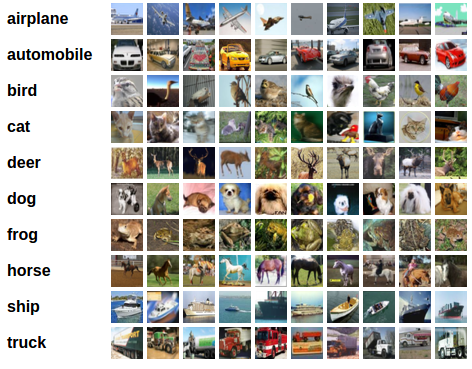

## Training an image classifier
We will do the following steps in order:
- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

## 1. Load and normalize CIFAR10
Using torchvision, it's extremely easy to load CIFAR10.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

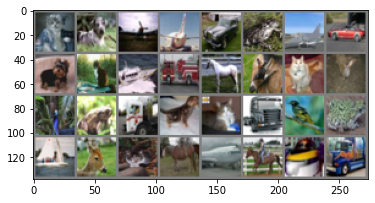

cat   dog   plane plane car   frog  plane car   dog   cat   ship  truck horse deer  cat   deer  bird  frog  truck cat   cat   truck bird  frog  ship  deer  cat   horse plane horse plane truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Define a Convolutional Neural Network


In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [39]:
def valid():
    correct = 0
    loss = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += criterion(outputs, labels).item()

    print(f"Loss of the network on the 10000 test images: {loss / total}")
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
    return loss, 100 * correct / total

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 115.52it/s, loss=1.62]


Loss of the network on the 10000 test images: 0.04461203384399414
Accuracy of the network on the 10000 test images: 47.88 %


Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 117.95it/s, loss=1.32]


Loss of the network on the 10000 test images: 0.03978988535404206
Accuracy of the network on the 10000 test images: 54.78 %


Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 115.48it/s, loss=1.19]


Loss of the network on the 10000 test images: 0.03761201981902122
Accuracy of the network on the 10000 test images: 56.72 %


Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 116.06it/s, loss=1.11]


Loss of the network on the 10000 test images: 0.03527580280303955
Accuracy of the network on the 10000 test images: 59.61 %


Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 116.46it/s, loss=1.04]


Loss of the network on the 10000 test images: 0.0343945015668869
Accuracy of the network on the 10000 test images: 61.0 %


Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 116.85it/s, loss=0.985]


Loss of the network on the 10000 test images: 0.033951012110710145
Accuracy of the network on the 10000 test images: 61.77 %


Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 117.33it/s, loss=0.937]


Loss of the network on the 10000 test images: 0.03345902561545372
Accuracy of the network on the 10000 test images: 62.58 %


Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 115.58it/s, loss=0.901]


Loss of the network on the 10000 test images: 0.03312670555710793
Accuracy of the network on the 10000 test images: 63.35 %


Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 117.21it/s, loss=0.863]


Loss of the network on the 10000 test images: 0.03364701135754585
Accuracy of the network on the 10000 test images: 63.44 %


Iter : 1562: 100%|██████████| 1563/1563 [00:13<00:00, 116.55it/s, loss=0.83] 


Loss of the network on the 10000 test images: 0.0340622439622879
Accuracy of the network on the 10000 test images: 62.73 %
Finished Training


<Figure size 360x216 with 0 Axes>

Text(0.5, 1.0, 'validation loss')

<Figure size 360x216 with 0 Axes>

Text(0.5, 1.0, 'validation acc')

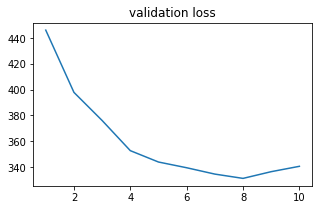

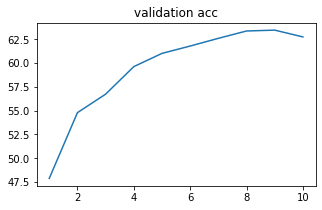

In [40]:

from tqdm import tqdm
import matplotlib.pyplot as plt
net.train()
dev_acc = []
dev_loss = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    loop = tqdm(iterable=trainloader)
    for i, data in enumerate(loop):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loop.set_description(f'Iter : {i}')
        loop.set_postfix(loss=running_loss / (i+1))
    
    loss, acc = valid()
    dev_acc.append(acc)
    dev_loss.append(loss)

print('Finished Training')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_loss)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_acc)
plt.title('validation acc')

Let’s quickly save our trained model:

In [87]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

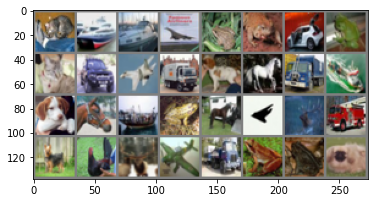

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 
GroundTruth:  cat   car   plane truck dog   horse truck ship 
GroundTruth:  dog   horse ship  frog  horse plane deer  truck
GroundTruth:  dog   bird  deer  plane truck frog  frog  dog  


In [91]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(0, 8)))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8, 16)))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16, 24)))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(24, 32)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [92]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [93]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [95]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(0, 8)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(8, 16)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(16, 24)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(24, 32)))

Predicted:  cat   car   ship  plane deer  frog  plane deer 
Predicted:  cat   car   deer  truck dog   horse truck ship 
Predicted:  dog   truck ship  frog  cat   bird  bird  truck
Predicted:  bird  deer  cat   plane truck frog  frog  dog  


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [96]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [97]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 72.5 %
Accuracy for class: car   is 72.1 %
Accuracy for class: bird  is 52.6 %
Accuracy for class: cat   is 41.5 %
Accuracy for class: deer  is 54.8 %
Accuracy for class: dog   is 46.1 %
Accuracy for class: frog  is 78.0 %
Accuracy for class: horse is 66.5 %
Accuracy for class: ship  is 67.9 %
Accuracy for class: truck is 73.1 %


## ResNet18

In [7]:

class BasicBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(BasicBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True), #inplace=True表示进行原地操作，一般默认为False，表示新建一个变量存储操作
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        #论文中模型架构的虚线部分，需要下采样
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
 
    def forward(self, x):
        out = self.left(x) #这是由于残差块需要保留原始输入
        out += self.shortcut(x)#这是ResNet的核心，在输出上叠加了输入x
        out = F.relu(out)
        return out


class ResNet_18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet_18, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)
 
    def make_layer(self, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)  # strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
 
    def forward(self, x):  # 3*32*32
        out = self.conv1(x)  # 64*32*32
        out = self.layer1(out)  # 64*32*32
        out = self.layer2(out)  # 128*16*16
        out = self.layer3(out)  # 256*8*8
        out = self.layer4(out)  # 512*4*4
        out = F.avg_pool2d(out, 4)  # 512*1*1
        out = out.view(out.size(0), -1)  # 512
        out = self.fc(out)
        return out
    
net = ResNet_18().to(device)
test_input = torch.rand(1, 3, 32, 32).to(device)
test_output = net(test_input)
print(test_output.shape)
print(net)

torch.Size([1, 10])
ResNet_18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

ResNet_18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplac

Iter : 1562: 100%|██████████| 1563/1563 [01:08<00:00, 22.76it/s, loss=1.31]


Loss of the network on the 10000 test images: 0.03035309954881668
Accuracy of the network on the 10000 test images: 65.63 %


Iter : 1562: 100%|██████████| 1563/1563 [01:08<00:00, 22.69it/s, loss=0.825]


Loss of the network on the 10000 test images: 0.023357880127429963
Accuracy of the network on the 10000 test images: 74.17 %


Iter : 1562: 100%|██████████| 1563/1563 [01:08<00:00, 22.72it/s, loss=0.609]


Loss of the network on the 10000 test images: 0.01896737030595541
Accuracy of the network on the 10000 test images: 79.23 %


Iter : 1562: 100%|██████████| 1563/1563 [01:09<00:00, 22.46it/s, loss=0.472]


Loss of the network on the 10000 test images: 0.01894212304353714
Accuracy of the network on the 10000 test images: 79.67 %


Iter : 1562: 100%|██████████| 1563/1563 [01:11<00:00, 21.97it/s, loss=0.361]


Loss of the network on the 10000 test images: 0.0179942066013813
Accuracy of the network on the 10000 test images: 81.01 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.08it/s, loss=0.266]


Loss of the network on the 10000 test images: 0.015945812077820302
Accuracy of the network on the 10000 test images: 83.86 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.26it/s, loss=0.183]


Loss of the network on the 10000 test images: 0.017774567046016456
Accuracy of the network on the 10000 test images: 83.4 %


Iter : 1562: 100%|██████████| 1563/1563 [01:09<00:00, 22.38it/s, loss=0.13] 


Loss of the network on the 10000 test images: 0.019124261823669077
Accuracy of the network on the 10000 test images: 83.37 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.03it/s, loss=0.0995]


Loss of the network on the 10000 test images: 0.02036056622713804
Accuracy of the network on the 10000 test images: 83.67 %


Iter : 1562: 100%|██████████| 1563/1563 [01:11<00:00, 22.00it/s, loss=0.0823]


Loss of the network on the 10000 test images: 0.021218849533051254
Accuracy of the network on the 10000 test images: 83.57 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.10it/s, loss=0.0675]


Loss of the network on the 10000 test images: 0.02186903465911746
Accuracy of the network on the 10000 test images: 83.39 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.07it/s, loss=0.0583]


Loss of the network on the 10000 test images: 0.022646414140984415
Accuracy of the network on the 10000 test images: 84.12 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.11it/s, loss=0.052] 


Loss of the network on the 10000 test images: 0.022773999004811047
Accuracy of the network on the 10000 test images: 84.18 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.03it/s, loss=0.0468]


Loss of the network on the 10000 test images: 0.024916047469899057
Accuracy of the network on the 10000 test images: 83.82 %


Iter : 1562: 100%|██████████| 1563/1563 [01:11<00:00, 21.99it/s, loss=0.0401]


Loss of the network on the 10000 test images: 0.023953779497742654
Accuracy of the network on the 10000 test images: 84.13 %


Iter : 1562: 100%|██████████| 1563/1563 [01:11<00:00, 21.93it/s, loss=0.0399]


Loss of the network on the 10000 test images: 0.024536160560324788
Accuracy of the network on the 10000 test images: 84.22 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.06it/s, loss=0.0368]


Loss of the network on the 10000 test images: 0.0250429883107543
Accuracy of the network on the 10000 test images: 84.04 %


Iter : 1562: 100%|██████████| 1563/1563 [01:11<00:00, 22.01it/s, loss=0.0365]


Loss of the network on the 10000 test images: 0.02594595472179353
Accuracy of the network on the 10000 test images: 84.02 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.05it/s, loss=0.0332]


Loss of the network on the 10000 test images: 0.02677318370640278
Accuracy of the network on the 10000 test images: 83.59 %


Iter : 1562: 100%|██████████| 1563/1563 [01:10<00:00, 22.05it/s, loss=0.0302]


Loss of the network on the 10000 test images: 0.02564165351986885
Accuracy of the network on the 10000 test images: 83.64 %
Finished Training


<Figure size 360x216 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

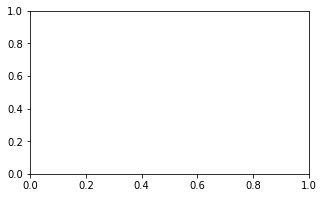

In [16]:
from tqdm import tqdm
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
dev_acc = []
dev_loss = []
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    loop = tqdm(iterable=trainloader)
    for i, data in enumerate(loop):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loop.set_description(f'Iter : {i}')
        loop.set_postfix(loss=running_loss / (i+1))

    loss, acc = valid()
    dev_acc.append(acc)
    dev_loss.append(loss)

print('Finished Training')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_loss)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_acc)
plt.title('validation acc')

<Figure size 360x216 with 0 Axes>

Text(0.5, 1.0, 'validation loss')

<Figure size 360x216 with 0 Axes>

Text(0.5, 1.0, 'validation acc')

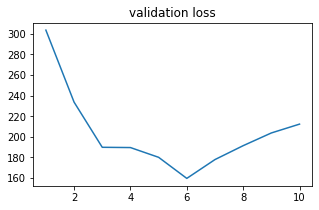

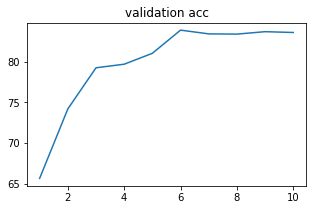

In [17]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_loss[:10])
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_acc[:10])
plt.title('validation acc')

In [18]:
resnet_acc = dev_acc[:10]
res_loss = dev_loss[:10]

In [8]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = resnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

NameError: name 'resnet' is not defined

## Se-ResNet

In [8]:
class SEModule(nn.Module):  # SE block
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.avg_pool(input)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input * x
    
class SEBasicBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(SEBasicBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True), #inplace=True表示进行原地操作，一般默认为False，表示新建一个变量存储操作
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        #论文中模型架构的虚线部分，需要下采样
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
        self.se = SEModule(outchannel)
 
    def forward(self, x):
        out = self.left(x) #这是由于残差块需要保留原始输入
        out += self.shortcut(x)#这是ResNet的核心，在输出上叠加了输入x
        out = F.relu(out)
        out = self.se(out)
        return out

class SE_ResNet_18(nn.Module):
    def __init__(self, num_classes=10):
        super(SE_ResNet_18, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)
 
    def make_layer(self, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)  # strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(SEBasicBlock(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
 
    def forward(self, x):  # 3*32*32
        out = self.conv1(x)  # 64*32*32
        out = self.layer1(out)  # 64*32*32
        out = self.layer2(out)  # 128*16*16
        out = self.layer3(out)  # 256*8*8
        out = self.layer4(out)  # 512*4*4
        out = F.avg_pool2d(out, 4)  # 512*1*1
        out = out.view(out.size(0), -1)  # 512
        out = self.fc(out)
        return out
    
net = SE_ResNet_18().to(device)
test_input = torch.rand(1, 3, 32, 32).to(device)
test_output = net(test_input)
print(test_output.shape)
print(net)

torch.Size([1, 10])
SE_ResNet_18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): SEBasicBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (se): SEModule(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1)

SE_ResNet_18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): SEBasicBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (se): SEModule(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
        (sigmoid):

Iter : 1562: 100%|██████████| 1563/1563 [01:17<00:00, 20.07it/s, loss=1.47]


Loss of the network on the 10000 test images: 0.03513651234507561
Accuracy of the network on the 10000 test images: 59.71 %


Iter : 1562: 100%|██████████| 1563/1563 [01:19<00:00, 19.69it/s, loss=0.956]


Loss of the network on the 10000 test images: 0.025889814168214797
Accuracy of the network on the 10000 test images: 71.45 %


Iter : 1562: 100%|██████████| 1563/1563 [01:20<00:00, 19.51it/s, loss=0.711]


Loss of the network on the 10000 test images: 0.020758368146419525
Accuracy of the network on the 10000 test images: 77.6 %


Iter : 1562: 100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s, loss=0.551]


Loss of the network on the 10000 test images: 0.01816849625557661
Accuracy of the network on the 10000 test images: 80.25 %


Iter : 1562: 100%|██████████| 1563/1563 [01:17<00:00, 20.23it/s, loss=0.435]


Loss of the network on the 10000 test images: 0.01693107351437211
Accuracy of the network on the 10000 test images: 81.79 %


Iter : 1562: 100%|██████████| 1563/1563 [01:20<00:00, 19.50it/s, loss=0.337]


Loss of the network on the 10000 test images: 0.0166534040145576
Accuracy of the network on the 10000 test images: 82.41 %


Iter : 1562: 100%|██████████| 1563/1563 [01:19<00:00, 19.65it/s, loss=0.256]


Loss of the network on the 10000 test images: 0.01701134073957801
Accuracy of the network on the 10000 test images: 83.01 %


Iter : 1562: 100%|██████████| 1563/1563 [01:20<00:00, 19.34it/s, loss=0.185]


Loss of the network on the 10000 test images: 0.018163747856765985
Accuracy of the network on the 10000 test images: 83.14 %


Iter : 1562: 100%|██████████| 1563/1563 [01:20<00:00, 19.52it/s, loss=0.131]


Loss of the network on the 10000 test images: 0.021191628661751748
Accuracy of the network on the 10000 test images: 82.55 %


Iter : 1562: 100%|██████████| 1563/1563 [01:19<00:00, 19.61it/s, loss=0.108]


Loss of the network on the 10000 test images: 0.021277664911746978
Accuracy of the network on the 10000 test images: 83.46 %
Finished Training


<Figure size 360x216 with 0 Axes>

Text(0.5, 1.0, 'validation loss')

<Figure size 360x216 with 0 Axes>

Text(0.5, 1.0, 'validation acc')

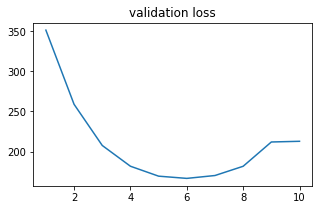

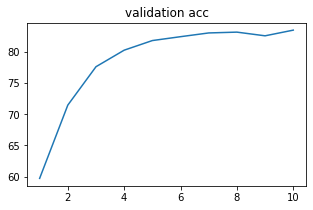

In [24]:
from tqdm import tqdm
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

dev_loss = []
dev_acc = []

net.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    loop = tqdm(iterable=trainloader)
    for i, data in enumerate(loop):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loop.set_description(f'Iter : {i}')
        loop.set_postfix(loss=running_loss / (i+1))

    loss, acc = valid()
    dev_acc.append(acc)
    dev_loss.append(loss)

print('Finished Training')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_loss)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_acc)
plt.title('validation acc')

In [25]:
seresnet_acc = dev_acc[:10]
seres_loss = dev_loss[:10]

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 84 %


DenseNet(
  (conv_1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn_1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn_1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn_1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_

DenseNet(
  (conv_1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn_1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn_1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn_1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_

Iter : 1562: 100%|██████████| 1563/1563 [00:40<00:00, 38.51it/s, loss=1.4] 


Loss of the network on the 10000 test images: 0.03558099081516266
Accuracy of the network on the 10000 test images: 58.8 %


Iter : 1562: 100%|██████████| 1563/1563 [00:41<00:00, 37.68it/s, loss=1]   


Loss of the network on the 10000 test images: 0.029330494529008867
Accuracy of the network on the 10000 test images: 66.7 %


Iter : 1562: 100%|██████████| 1563/1563 [00:41<00:00, 37.65it/s, loss=0.864]


Loss of the network on the 10000 test images: 0.026642007675766945
Accuracy of the network on the 10000 test images: 69.66 %


Iter : 1562: 100%|██████████| 1563/1563 [00:42<00:00, 36.75it/s, loss=0.776]


Loss of the network on the 10000 test images: 0.02462929493188858
Accuracy of the network on the 10000 test images: 72.2 %


Iter : 1562: 100%|██████████| 1563/1563 [00:41<00:00, 37.42it/s, loss=0.713]


Loss of the network on the 10000 test images: 0.022885845187306405
Accuracy of the network on the 10000 test images: 74.25 %


Iter : 1562: 100%|██████████| 1563/1563 [00:45<00:00, 34.49it/s, loss=0.656]


Loss of the network on the 10000 test images: 0.021606178283691407
Accuracy of the network on the 10000 test images: 76.55 %


Iter : 1562: 100%|██████████| 1563/1563 [00:46<00:00, 33.34it/s, loss=0.61] 


Loss of the network on the 10000 test images: 0.020843677389621736
Accuracy of the network on the 10000 test images: 76.94 %


Iter : 1562: 100%|██████████| 1563/1563 [00:47<00:00, 32.94it/s, loss=0.57] 


Loss of the network on the 10000 test images: 0.019858438539505006
Accuracy of the network on the 10000 test images: 78.0 %


Iter : 1562: 100%|██████████| 1563/1563 [00:45<00:00, 34.58it/s, loss=0.536]


Loss of the network on the 10000 test images: 0.019901338325440884
Accuracy of the network on the 10000 test images: 78.35 %


Iter : 1562: 100%|██████████| 1563/1563 [00:46<00:00, 33.34it/s, loss=0.512]


Loss of the network on the 10000 test images: 0.01945637905448675
Accuracy of the network on the 10000 test images: 78.47 %


Iter : 1562: 100%|██████████| 1563/1563 [00:45<00:00, 33.99it/s, loss=0.486]


Loss of the network on the 10000 test images: 0.0192656456887722
Accuracy of the network on the 10000 test images: 79.06 %


Iter : 1562: 100%|██████████| 1563/1563 [00:47<00:00, 32.87it/s, loss=0.466]


Loss of the network on the 10000 test images: 0.018526045390963555
Accuracy of the network on the 10000 test images: 79.77 %


Iter : 1562: 100%|██████████| 1563/1563 [00:44<00:00, 35.24it/s, loss=0.444]


Loss of the network on the 10000 test images: 0.01847126159593463
Accuracy of the network on the 10000 test images: 79.66 %


Iter : 1562: 100%|██████████| 1563/1563 [00:42<00:00, 36.75it/s, loss=0.427]


Loss of the network on the 10000 test images: 0.018236773236095905
Accuracy of the network on the 10000 test images: 80.46 %


Iter : 1562: 100%|██████████| 1563/1563 [00:41<00:00, 37.22it/s, loss=0.408]


Loss of the network on the 10000 test images: 0.01876358513236046
Accuracy of the network on the 10000 test images: 79.37 %


Iter : 1562: 100%|██████████| 1563/1563 [00:42<00:00, 36.97it/s, loss=0.39] 


Loss of the network on the 10000 test images: 0.018465524142980576
Accuracy of the network on the 10000 test images: 80.05 %


Iter : 1562: 100%|██████████| 1563/1563 [00:41<00:00, 37.28it/s, loss=0.376]


Loss of the network on the 10000 test images: 0.01873908385783434
Accuracy of the network on the 10000 test images: 80.24 %


Iter : 1562: 100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s, loss=0.361]


Loss of the network on the 10000 test images: 0.019401344111561775
Accuracy of the network on the 10000 test images: 79.5 %


Iter : 1562: 100%|██████████| 1563/1563 [00:42<00:00, 37.05it/s, loss=0.351]


Loss of the network on the 10000 test images: 0.018600132660567762
Accuracy of the network on the 10000 test images: 80.67 %


Iter : 1562: 100%|██████████| 1563/1563 [00:41<00:00, 37.57it/s, loss=0.34] 


Loss of the network on the 10000 test images: 0.018808574543893338
Accuracy of the network on the 10000 test images: 80.39 %
Finished Training


<Figure size 360x216 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

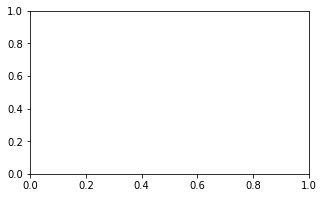

In [26]:
from densenet import densenet22bc
from tqdm import tqdm
import torch.optim as optim

net = densenet22bc(10)
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

dev_loss = []
dev_acc = []

net.train()
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    loop = tqdm(iterable=trainloader)
    for i, data in enumerate(loop):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loop.set_description(f'Iter : {i}')
        loop.set_postfix(loss=running_loss / (i+1))

    loss, acc = valid()
    dev_acc.append(acc)
    dev_loss.append(loss)

print('Finished Training')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_loss)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dev_acc)
plt.title('validation acc')

In [27]:
dense_acc = dev_acc[:10]
dense_loss = dev_loss[:10]

<Figure size 360x216 with 0 Axes>

Text(0.5, 1.0, 'validation loss')

<Figure size 360x216 with 0 Axes>

Text(0.5, 1.0, 'validation acc')

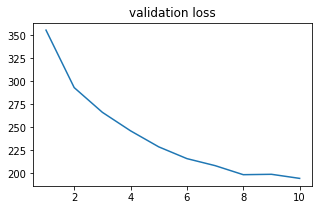

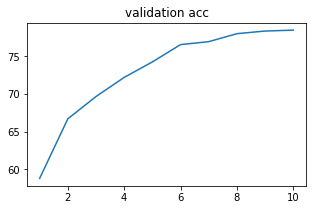

In [28]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dense_loss)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,11), dense_acc)
plt.title('validation acc')

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = densenet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %


<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'validation loss')

<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'validation acc')

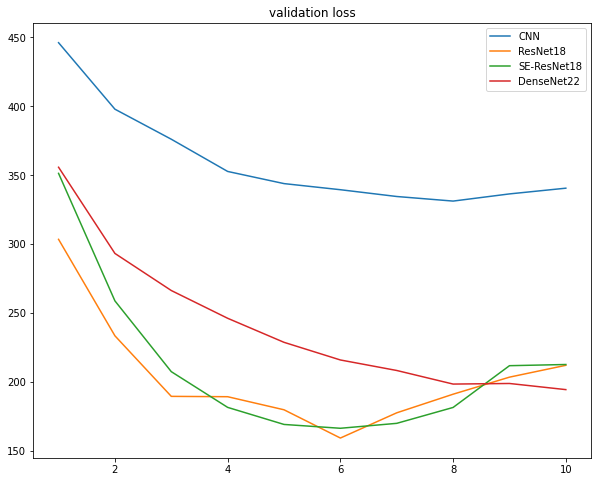

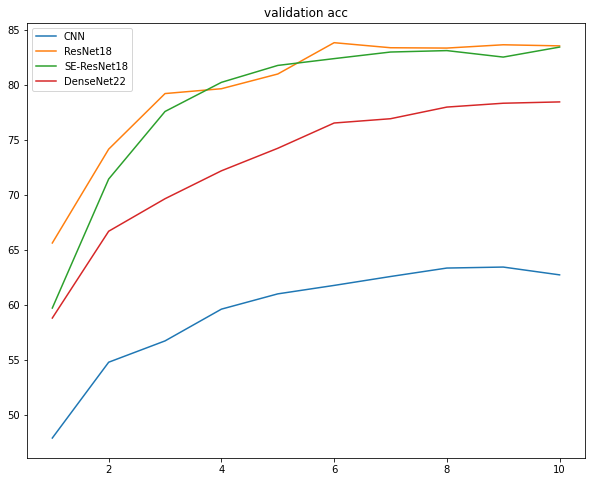

In [41]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(1,11), dev_loss)
plt.plot(np.arange(1,11), res_loss)
plt.plot(np.arange(1,11), seres_loss)
plt.plot(np.arange(1,11), dense_loss)
plt.legend(['CNN', 'ResNet18', 'SE-ResNet18', 'DenseNet22'])
plt.title('validation loss')

plt.figure(figsize=(10, 8))
plt.plot(np.arange(1,11), dev_acc)
plt.plot(np.arange(1,11), resnet_acc)
plt.plot(np.arange(1,11), seresnet_acc)
plt.plot(np.arange(1,11), dense_acc)
plt.legend(['CNN', 'ResNet18', 'SE-ResNet18', 'DenseNet22'])
plt.title('validation acc')